In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler

#데이터분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

#모델링
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#성과 평가 지표
from sklearn.metrics import accuracy_score, mean_squared_error

In [3]:
train=pd.read_csv('../train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('../test.csv', index_col=0)
submission=pd.read_csv('../sample_submission.csv', index_col=0) 

In [4]:
print(train.shape)
print(test.shape)
print(submission.shape)

(26049, 15)
(6512, 14)
(6512, 1)


In [5]:
alldata=pd.concat([train,test], sort=False)

## EDA

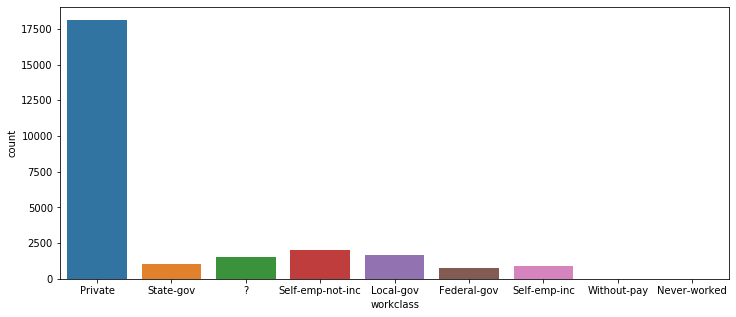

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax =plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=train, x='workclass')

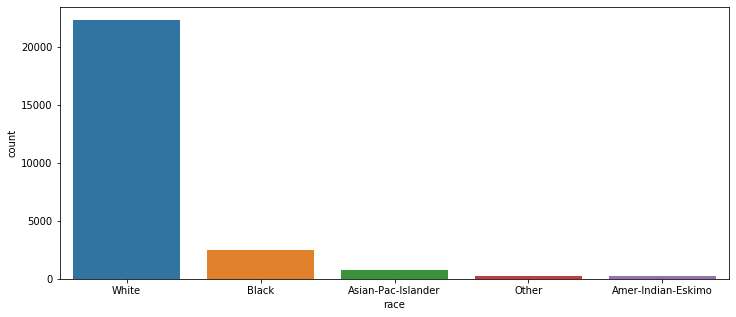

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax =plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=train, x='race')

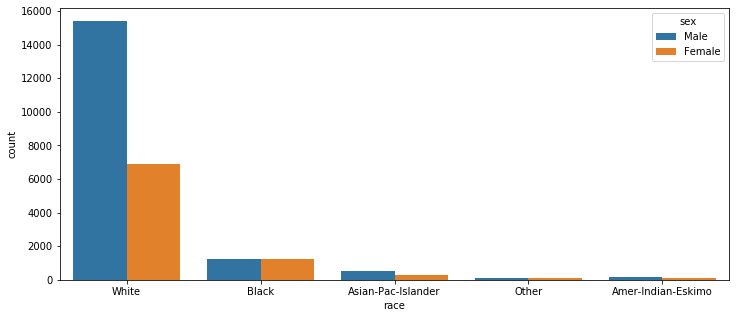

In [8]:
fig, ax =plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=train, x='race', hue='sex')

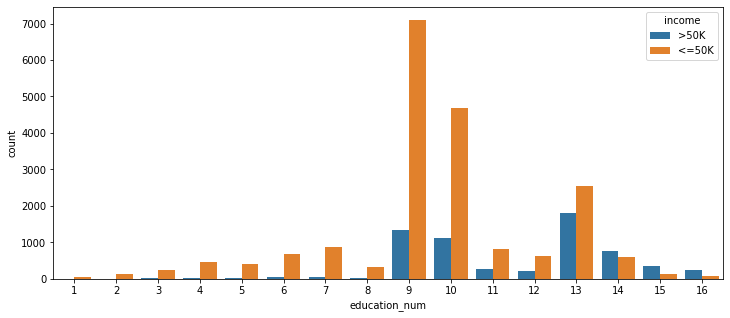

In [9]:
fig, ax =plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=alldata, x='education_num', hue='income')

In [10]:
alldata['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [11]:
alldata['age'].value_counts()

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

In [12]:
alldata['agegroup']=(alldata['age']<70).astype('int')

In [13]:
alldata.sort_values(by='age')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,agegroup
id,,,,,,,,,,,,,,,,
1376,17,Private,46402,7th-8th,4,Never-married,Sales,Own-child,White,Male,0,0,8,United-States,<=50K,1
18268,17,?,634226,10th,6,Never-married,?,Own-child,White,Female,0,0,17,United-States,<=50K,1
2649,17,?,280670,10th,6,Never-married,?,Own-child,White,Female,0,0,40,United-States,NaN,1
15808,17,Private,295488,11th,7,Never-married,Other-service,Own-child,Black,Female,0,0,25,United-States,<=50K,1
5155,17,Private,117477,10th,6,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,<=50K,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22333,90,Private,87285,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,24,United-States,<=50K,0
3431,90,Self-emp-not-inc,155981,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,10566,0,50,United-States,<=50K,0
13118,90,Private,313749,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,25,United-States,<=50K,0


In [14]:
alldata['income']= (alldata['income']=='>50K').astype('int')

In [15]:
alldata.groupby(['education'])['income'].agg(['mean', 'count']).sort_values('mean')

,mean,count
education,,
Preschool,0.000000,51
1st-4th,0.029762,168
5th-6th,0.039039,333
9th,0.042802,514
7th-8th,0.044892,646
11th,0.046809,1175
10th,0.056806,933
12th,0.060046,433
HS-grad,0.127321,10501


In [16]:
from statsmodels.formula.api import ols

res = ols('income ~ occupation', data=alldata).fit()

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence
cd, _ = OLSInfluence(res).cooks_distance
cd.sort_values(ascending=False).head()


id
9249     0.003164
6830     0.000402
24276    0.000402
15144    0.000402
14056    0.000402
dtype: float64

In [18]:
workclass_other = ['Without-pay', 'Never-worked']
alldata['workclass'] = alldata['workclass'].apply(lambda x: 'Other' if x in workclass_other else x)

In [19]:
alldata['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Other                  21
Name: workclass, dtype: int64

### 교육수준 범주화

- 변수를 줄이며 과대적합을 방지해 줄 수 있으며 시간비용도 아낄 수 있다.

- 비슷한 수준끼리 묶어주는 과정

In [20]:
education_map = {
    'Preschool': 'level_0', 
    '1st-4th': 'level_1', 
    '5th-6th': 'level_1', 
    '7th-8th': 'level_2', 
    '9th': 'level_2', 
    '10th': 'level_3', 
    '11th': 'level_3', 
    '12th': 'level_3', 
    'HS-grad': 'level_4', 
    'Some-college': 'level_5', 
    'Assoc-acdm': 'level_6', 
    'Assoc-voc': 'level_6', 
    'Bachelors': 'level_7', 
    'Masters': 'level_8', 
    'Prof-school': 'level_9', 
    'Doctorate': 'level_9',
}

In [21]:
alldata['education'] = alldata['education'].map(education_map)

In [22]:
alldata['education'].value_counts()


level_4    10501
level_5     7291
level_7     5355
level_6     2449
level_2     2335
level_8     1723
level_3     1366
level_9      989
level_1      501
level_0       51
Name: education, dtype: int64

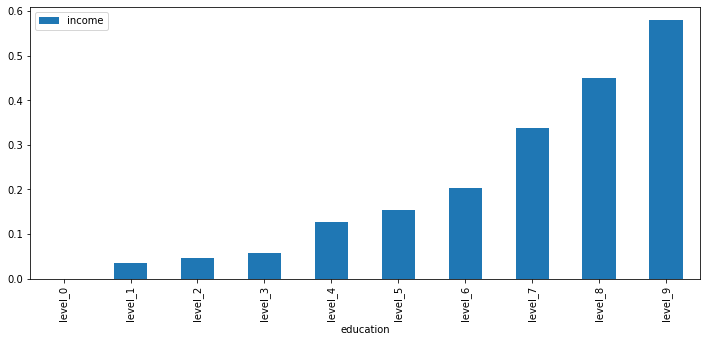

In [23]:
alldata.pivot_table(index='education', values=['income']).sort_values('income').plot(kind='bar', figsize=(12,5))

교육수준과 수입간의 관계가 있는것으로 보임

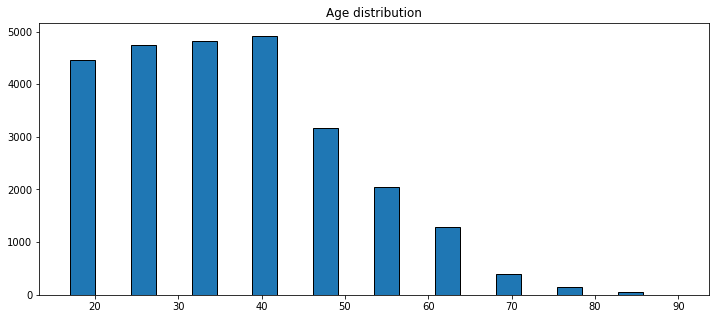

In [24]:
import matplotlib as mpl

fig,ax=plt.subplots(1,1, figsize=(12,5))
ax.hist(train['age'],width=3, edgecolor='black')

ax.set_title('Age distribution')
plt.show()

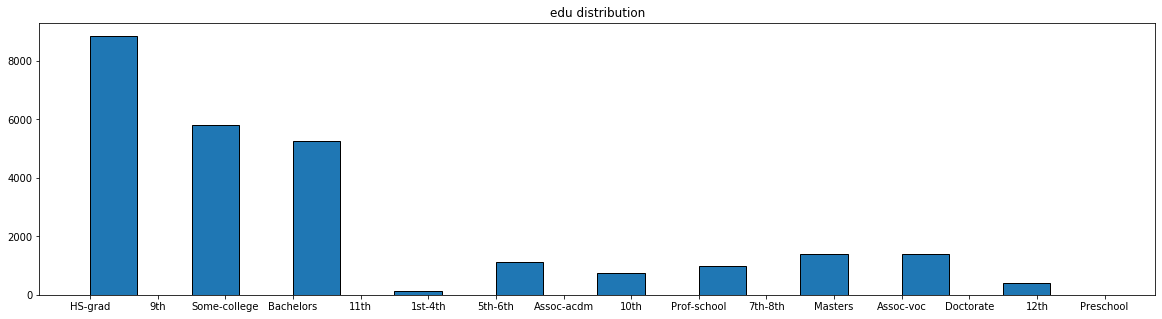

In [25]:
import matplotlib as mpl

fig,ax=plt.subplots(1,1, figsize=(20,5))
ax.hist(train['education'],width=0.7, edgecolor='black')

ax.set_title('edu distribution')
plt.show()

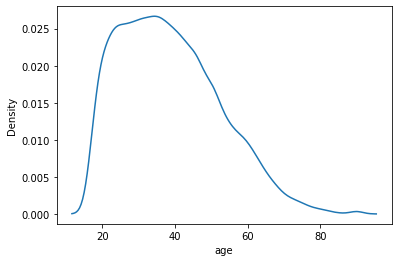

In [26]:
#sns.displot()
sns.kdeplot(data=train, x='age')

In [27]:
alldata['income'].value_counts()

0    26256
1     6305
Name: income, dtype: int64

In [28]:
train.groupby(['race','sex']).mean()

age         fnlwgt  education_num  \
race               sex                                               
Amer-Indian-Eskimo Female  37.454545  117238.954545       9.761364   
                   Male    36.915663  125551.475904       9.090361   
Asian-Pac-Islander Female  35.181481  146863.433333      10.325926   
                   Male    38.884906  166262.398113      11.233962   
Black              Female  37.939295  216797.705496       9.525021   
                   Male    37.884646  243795.577566       9.482896   
Other              Female  31.435294  173440.082353       8.941176   
                   Male    34.789916  220238.193277       8.907563   
White              Female  36.844026  184007.053584      10.127589   
                   Male    39.589163  189231.912524      10.149254   

                           capital_gain  capital_loss  hours_per_week  
race               sex                                                 
Amer-Indian-Eskimo Female    646.636364     19.556818       36.204545  
                   Male      649.596386     53.662651       41.837349  
Asian-Pac-Islander Female    584.325926     61.122222       37.407407  
                   Male     2026.226415    135.403774       42.037736  
Black              Female    487.988515     40.462674       36.796555  
                   Male      579.319809     76.113763       39.976134  
Other              Female    236.129412     39.176471       36.670588  
                   Male     1799.764706     87.529412       41.403361  
White              Female    580.929761     63.601738       36.209269  
                   Male     1386.644906    103.084945       42.687735

백인 남성의 31%는 수익이 50불을 넘는다. 백인 여성의 12%이상만 수익이 50불을 넘는다. 

In [29]:
alldata.groupby(['race','sex'])[['income']].mean().style.background_gradient(cmap='Purples')

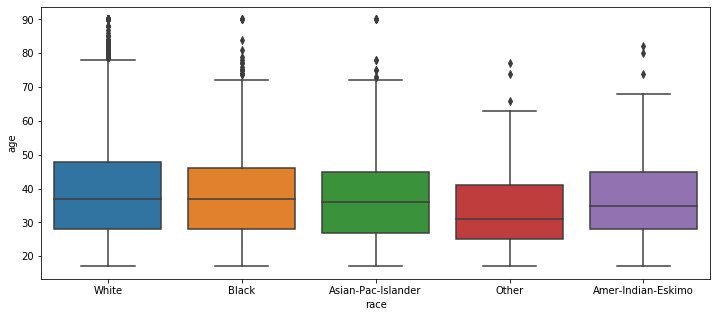

In [32]:
fig, ax= plt.subplots(1,1, figsize=(12,5))
sns.boxplot(data=train, x='race', y='age')
#sns.violinplot()
#swarmplot

In [33]:
train.corr().style.background_gradient()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.076618,0.040107,0.077768,0.057875,0.066038
fnlwgt,-0.076618,1.000000,-0.046377,0.000953,-0.008689,-0.020064
education_num,0.040107,-0.046377,1.000000,0.119382,0.074813,0.146063
capital_gain,0.077768,0.000953,0.119382,1.000000,-0.032030,0.080543
capital_loss,0.057875,-0.008689,0.074813,-0.032030,1.000000,0.054957
hours_per_week,0.066038,-0.020064,0.146063,0.080543,0.054957,1.000000


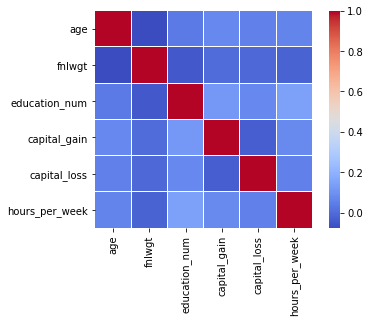

In [34]:
corr=train.corr()
sns.heatmap(corr, square=True, linecolor='White',linewidth=0.1, cmap='coolwarm')

In [35]:
import seaborn as sns
print(sns.__version__)

0.11.0


In [36]:
train_clean = alldata[:len(train)]
test_clean = alldata[len(train):]

<BarContainer object of 2 artists>

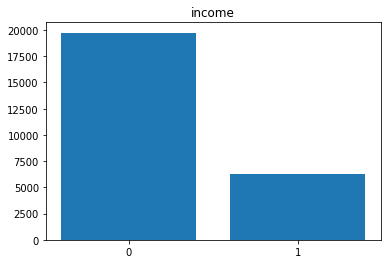

In [37]:
train_y = train_clean['income']

tar = [str(train_y.unique()[1]), str(train_y.unique()[0])]
count= [train_y.value_counts()[0], train_y.value_counts()[1]]
plt.title('income')
plt.bar(tar, count)

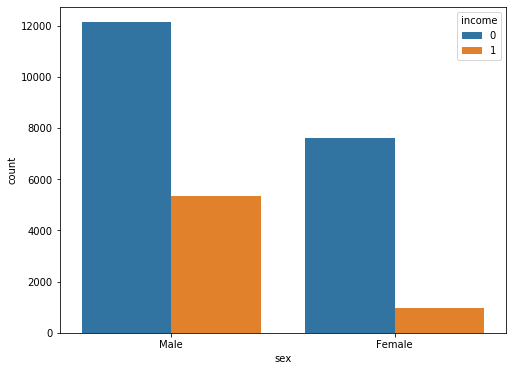

In [38]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'sex', hue = train_y)

남성과 여성의 수입에 차이가 있어보인다.

In [39]:
from sklearn.preprocessing import MinMaxScaler

train_X=train_clean.drop(['income'],axis=1)





In [173]:
X_train, X_val, y_train, y_val = train_test_split(train_X, 

                                                    train_y, 

                                                    test_size=0.2, 

                                                    shuffle=True, 

                                                    random_state=1)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

### 변수중요도를 통한 변수선택

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10).fit(X_train_scaled, y_train)
cross_val_score(rf, X_train_scaled, y_train, cv=3)
rf.score(X_test_scaled, y_val)
print(classification_report(y_val, rf.predict(X_test_scaled)))

feature_importance_rf = pd.DataFrame(zip(train.columns.values, rf.feature_importances_))
feature_importance_rf.columns = ['feature', 'importance']
feature_importance_rf.sort_values("importance", ascending=False, inplace=True)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3962
           1       0.75      0.59      0.66      1248

    accuracy                           0.85      5210
   macro avg       0.81      0.76      0.78      5210
weighted avg       0.85      0.85      0.85      5210



In [42]:
feature_importance_rf ## 중요도가 많이 낮은 변수가 없어서 제거해주진 못할 것 같다.

,feature,importance
2,fnlwgt,0.158883
0,age,0.146905
10,capital_gain,0.115391
7,relationship,0.099458
4,education_num,0.091559
5,marital_status,0.085551
12,hours_per_week,0.082419
6,occupation,0.068433
1,workclass,0.040773
11,capital_loss,0.035203


In [40]:
from pycaret.classification import *


In [87]:
alldata.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
id,,,,,,,,,,,,,,,
0,1,Private,168538,level_4,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,1
1,1,Private,101626,level_2,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,0
2,1,Private,353358,level_5,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,0
3,1,Private,151158,level_5,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,0
4,1,Private,122234,level_5,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,0


In [41]:
train_clean = alldata[:len(train)]
test_clean = alldata[len(train):]

In [42]:
drop_last = ['sex']
new_train= train.drop(drop_last, axis = 1)
test = test.drop(drop_last, axis = 1)

## Auto ML

In [43]:
clf = setup(data = train_clean, target = 'income')


,Description,Value
0,session_id,540
1,Target,income
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(26049, 16)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [44]:
best_model = compare_models(sort='F1')


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8710,0.9275,0.7944,0.8665,0.8665,0.6255,0.6306,4.1670
lightgbm,Light Gradient Boosting Machine,0.8690,0.9252,0.7949,0.8645,0.8650,0.6223,0.6263,0.1330
xgboost,Extreme Gradient Boosting,0.8666,0.9233,0.7937,0.8622,0.8628,0.6171,0.6206,0.8940
gbc,Gradient Boosting Classifier,0.8645,0.9193,0.7739,0.8594,0.8576,0.5969,0.6065,0.4260
ada,Ada Boost Classifier,0.8601,0.9154,0.7780,0.8546,0.8549,0.5926,0.5980,0.1150
rf,Random Forest Classifier,0.8526,0.9026,0.7713,0.8469,0.8479,0.5743,0.5783,0.3410
lda,Linear Discriminant Analysis,0.8391,0.8929,0.7450,0.8312,0.8323,0.5273,0.5334,0.1390
ridge,Ridge Classifier,0.8384,0.0000,0.7261,0.8296,0.8271,0.5060,0.5203,0.0110
et,Extra Trees Classifier,0.8294,0.8754,0.7489,0.8241,0.8260,0.5169,0.5185,0.4510
dt,Decision Tree Classifier,0.8161,0.7516,0.7516,0.8171,0.8165,0.5007,0.5009,0.0300


In [175]:
xgboost = create_model('xgboost')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8712,0.9222,0.6553,0.7769,0.7109,0.6288,0.6326
1,0.8849,0.9370,0.6855,0.8102,0.7426,0.6692,0.6730
2,0.8871,0.9440,0.7081,0.8026,0.7524,0.6796,0.6819
3,0.8750,0.9277,0.6900,0.7702,0.7279,0.6471,0.6487
4,0.8618,0.9153,0.6463,0.7480,0.6934,0.6048,0.6075
5,0.8623,0.9230,0.6349,0.7568,0.6905,0.6028,0.6067
6,0.8612,0.9115,0.6349,0.7527,0.6888,0.6003,0.6039
7,0.8832,0.9386,0.7007,0.7923,0.7437,0.6684,0.6705
8,0.8651,0.9179,0.6395,0.7642,0.6963,0.6104,0.6144
9,0.8651,0.9266,0.6576,0.7532,0.7022,0.6155,0.6178


In [181]:
tuned_xgboost = tune_model(xgboost, optimize='F1')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8569,0.9116,0.6327,0.7381,0.6813,0.5898,0.5927
1,0.8651,0.9188,0.6357,0.7678,0.6955,0.6099,0.6144
2,0.8777,0.9366,0.7036,0.7717,0.7361,0.6568,0.6579
3,0.8646,0.9201,0.6719,0.7444,0.7063,0.6186,0.6200
4,0.8491,0.9030,0.6145,0.7207,0.6634,0.5670,0.5700
5,0.8546,0.9126,0.6168,0.7391,0.6724,0.5800,0.5839
6,0.8475,0.9079,0.6122,0.7162,0.6601,0.5626,0.5655
7,0.8651,0.9210,0.6599,0.7519,0.7029,0.6161,0.6183
8,0.8651,0.9141,0.6485,0.7586,0.6993,0.6130,0.6161
9,0.8634,0.9139,0.6712,0.7400,0.7039,0.6154,0.6167


In [177]:
lgbm = create_model('lightgbm')
cb=create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8706,0.9236,0.6327,0.7904,0.7028,0.6214,0.6277
1,0.8854,0.9398,0.6629,0.8300,0.7371,0.6650,0.6719
2,0.8931,0.9473,0.7195,0.8175,0.7653,0.6965,0.6989
3,0.8750,0.9304,0.6878,0.7716,0.7273,0.6465,0.6483
4,0.8667,0.9174,0.6259,0.7797,0.6943,0.6104,0.6164
5,0.8689,0.9286,0.6304,0.7853,0.6994,0.6168,0.6229
6,0.8590,0.9143,0.6122,0.7584,0.6775,0.5886,0.5942
7,0.8821,0.9370,0.6757,0.8054,0.7349,0.6598,0.6640
8,0.8771,0.9231,0.6576,0.7989,0.7214,0.6435,0.6485
9,0.8733,0.9303,0.6712,0.7749,0.7193,0.6380,0.6408


In [ ]:
stacker1 = stack_models(estimator_list = best_model[3:4], meta_model = best_model[3])

In [172]:
#et = create_model('et')
ada = create_model('ada')
rf = create_model('rf')
#gbr = create_model('gbr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8377,0.8634,0.5760,0.6997,0.6318,0.5290,0.5331
1,0.8492,0.8796,0.5701,0.7478,0.6470,0.5533,0.5616
2,0.8586,0.9040,0.6244,0.7500,0.6815,0.5915,0.5956
3,0.8575,0.8883,0.6154,0.7514,0.6766,0.5864,0.5912
4,0.8300,0.8601,0.5283,0.6955,0.6005,0.4950,0.5026
5,0.8442,0.8833,0.5850,0.7187,0.6450,0.5465,0.5513
6,0.8371,0.8662,0.5465,0.7130,0.6187,0.5174,0.5248
7,0.8409,0.8820,0.5669,0.7163,0.6329,0.5331,0.5391
8,0.8481,0.8783,0.5873,0.7316,0.6516,0.5559,0.5614
9,0.8546,0.8938,0.6259,0.7340,0.6756,0.5827,0.5858


In [182]:
model=[[lgbm, xgboost, ada], [ cb, rf]]

In [188]:
automl()

In [ ]:
blender_specific = blend_models(estimator_list = [stacker,stacker1], method = 'soft')

In [151]:
pred_holdout = predict_model(blender_specific)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8708,0.9262,0.6438,0.7838,0.7069,0.625,0.63


In [154]:
final_model = finalize_model(stacker)


In [155]:
predictions = predict_model(final_model, data = test)


In [156]:
predictions

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Label,Score
0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States,<=50K,0.0006
1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K,0.5336
2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States,<=50K,0.0002
3,40,Private,114537,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K,0.6772
4,37,Private,51264,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,France,<=50K,0.3083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,35,Private,61343,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K,0.5158
6508,41,Self-emp-inc,32185,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K,0.5979
6509,39,Private,409189,5th-6th,3,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Mexico,<=50K,0.0087
6510,35,Private,180342,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K,0.1913


In [15]:
predictions

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Label,Score
0,28,4,67661,15,10,4,1,2,4,0,0,0,40,39,0,0.0040
1,40,5,37869,11,9,2,4,0,4,1,0,0,50,39,1,0.5322
2,20,4,109952,15,10,4,6,3,4,1,0,0,25,39,0,0.0002
3,40,4,114537,8,11,2,4,0,4,1,0,0,50,39,1,0.6609
4,37,4,51264,10,16,2,10,0,4,1,0,0,99,10,1,0.5128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,35,4,61343,9,13,2,12,0,4,1,0,0,40,39,1,0.5358
6508,41,5,32185,9,13,2,13,0,4,1,0,0,40,39,1,0.6085
6509,39,4,409189,4,3,2,8,0,4,1,0,0,40,26,0,0.0364
6510,35,4,180342,11,9,2,3,0,4,1,0,0,40,39,0,0.2348


In [157]:
submission['prediction'] = predictions['Score']


In [158]:
submission

,prediction
id,
0,0.0006
1,0.5336
2,0.0002
3,0.6772
4,0.3083
...,...
6507,0.5158
6508,0.5979
6509,0.0087


In [159]:
submission.loc[submission['prediction'] <= 0.5, 'prediction'] = 0

In [161]:
submission.loc[submission['prediction'] >= 0.5, 'prediction'] = 1

In [164]:
submission

,prediction
id,
0,0
1,1
2,0
3,1
4,0
...,...
6507,1
6508,1
6509,0


In [163]:
submission['prediction']=submission['prediction'].astype('int')

In [165]:
submission.to_csv('submission1.csv', index = True)

In [166]:
submission

,prediction
id,
0,0
1,1
2,0
3,1
4,0
...,...
6507,1
6508,1
6509,0


In [60]:
train

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,,
0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States
1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States
2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States
3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States
4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,57,Private,250201,11th,7,Married-civ-spouse,Other-service,Husband,White,Male,0,0,52,United-States
26045,23,Private,238092,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
26046,78,?,165694,Masters,14,Widowed,?,Not-in-family,White,Female,0,0,15,United-States


## Deep Learning 모델 시도

In [4]:
label = LabelEncoder()
train['workclass'] = label.fit_transform(train['workclass'])
train['education'] = label.fit_transform(train['education'])
train['marital_status'] = label.fit_transform(train['marital_status'])
train['occupation'] = label.fit_transform(train['occupation'])
train['relationship'] = label.fit_transform(train['relationship'])
train['race'] = label.fit_transform(train['race'])
train['sex'] = label.fit_transform(train['sex'])
train['native_country'] = label.fit_transform(train['native_country'])
train['income'] = label.fit_transform(train['income'])


test['workclass'] = label.fit_transform(test['workclass'])
test['education'] = label.fit_transform(test['education'])
test['marital_status'] = label.fit_transform(test['marital_status'])
test['occupation'] = label.fit_transform(test['occupation'])
test['relationship'] = label.fit_transform(test['relationship'])
test['race'] = label.fit_transform(test['race'])
test['sex'] = label.fit_transform(test['sex'])
test['native_country'] = label.fit_transform(test['native_country'])



In [5]:
train

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
id,,,,,,,,,,,,,,,
0,40,4,168538,11,9,2,12,0,4,1,0,0,60,38,1
1,17,4,101626,6,5,4,7,3,4,1,0,0,20,38,0
2,18,4,353358,15,10,4,8,3,4,1,0,0,16,38,0
3,21,4,151158,15,10,4,10,3,4,0,0,0,25,38,0
4,24,4,122234,15,10,4,1,1,2,0,0,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,57,4,250201,1,7,2,8,0,4,1,0,0,52,38,0
26045,23,4,238092,9,13,4,10,3,4,1,0,0,40,38,0
26046,78,0,165694,12,14,6,0,1,4,0,0,0,15,38,0


In [6]:
train_y=train['income']
train_y

id
0        1
1        0
2        0
3        0
4        0
        ..
26044    0
26045    0
26046    0
26047    0
26048    0
Name: income, Length: 26049, dtype: int64

In [7]:
train=train.drop(['income'],axis=1)

In [8]:
new_train = (train - train.mean())/train.std()
new_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,,
0,0.104653,0.094013,-0.205409,0.180733,-0.423885,-0.408957,1.277106,-0.901521,0.389935,0.700020,-0.147207,-0.217575,1.582035,0.290332
1,-1.577680,0.094013,-0.836856,-1.116712,-1.981754,0.919254,0.097212,0.965081,0.389935,0.700020,-0.147207,-0.217575,-1.653727,0.290332
2,-1.504535,0.094013,1.538730,1.218689,-0.034418,0.919254,0.333191,0.965081,0.389935,0.700020,-0.147207,-0.217575,-1.977303,0.290332
3,-1.285100,0.094013,-0.369424,1.218689,-0.034418,0.919254,0.805148,0.965081,0.389935,-1.428476,-0.147207,-0.217575,-1.249257,0.290332
4,-1.065666,0.094013,-0.642379,1.218689,-0.034418,0.919254,-1.318659,-0.279320,-1.979972,-1.428476,-0.147207,-0.217575,-1.653727,-4.753871


In [9]:
test= (test - test.mean())/test.std()
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,,
0,-0.786547,0.073824,-1.155644,1.199959,-0.019247,0.931063,-1.314402,0.351298,0.408386,-1.397973,-0.140743,-0.212956,-0.033747,0.301385
1,0.101262,0.774616,-1.442521,0.183685,-0.404896,-0.395216,-0.598953,-0.894699,0.408386,0.715212,-0.140743,-0.212956,0.779890,0.301385
2,-1.378420,0.073824,-0.748410,1.199959,-0.019247,0.931063,-0.121988,0.974296,0.408386,0.715212,-0.140743,-0.212956,-1.254203,0.301385
3,0.101262,0.073824,-0.704259,-0.578521,0.366402,-0.395216,-0.598953,-0.894699,0.408386,0.715212,-0.140743,-0.212956,0.779890,0.301385
4,-0.120690,0.073824,-1.313536,-0.070384,2.294646,-0.395216,0.831943,-0.894699,0.408386,0.715212,-0.140743,-0.212956,4.766712,-3.233548


In [10]:
M,N =new_train.shape
input_shape=(1,M,N)
input_shape

(1, 26049, 14)

In [127]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

model = models.Sequential()
model.add(layers.Dense(1028, activation='relu', input_shape=input_shape))

model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(4, activation='relu'))
model.add(Dropout(0.5))
x = GlobalAveragePooling2D(data_format='channels_last')(x)




model.add(layers.Dense(1, activation='sigmoid')) 

In [139]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1, 26049, 1028)    15420     
_________________________________________________________________
dense_31 (Dense)             (None, 1, 26049, 256)     263424    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 26049, 256)     0         
_________________________________________________________________
dense_32 (Dense)             (None, 1, 26049, 32)      8224      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 26049, 32)      0         
_________________________________________________________________
dense_33 (Dense)             (None, 1, 26049, 16)      528       
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 26049, 16)     

In [128]:
from tensorflow.keras.optimizers import Adam

adam = Adam(lr=0.001)


In [129]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [130]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics='AUC')

In [131]:
X_train, X_val, y_train, y_val = train_test_split(new_train, 

                                                    train_y, 

                                                    test_size=0.2, 

                                                    shuffle=True, 

                                                    random_state=1)


In [132]:
X_val

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,,
11389,0.762958,0.094013,1.259537,-2.414157,-1.202820,-0.408957,0.569170,0.342880,0.389935,-1.428476,-0.147207,-0.217575,-0.035846,0.290332
20330,-0.334216,2.144487,0.179420,1.218689,-0.034418,-0.408957,1.041127,-0.901521,0.389935,0.700020,-0.147207,-0.217575,-0.035846,0.290332
15610,1.933276,0.094013,0.160207,1.218689,-0.034418,-0.408957,1.041127,-0.901521,0.389935,0.700020,-0.147207,-0.217575,-1.977303,0.290332
15329,0.324088,2.144487,0.483187,-0.338245,1.133984,-1.737168,0.805148,1.587281,0.389935,-1.428476,0.056614,-0.217575,-0.359422,0.290332
6619,-0.773086,0.094013,-0.850133,0.180733,-0.423885,0.919254,0.097212,0.965081,0.389935,0.700020,-0.147207,-0.217575,0.368624,0.290332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,-1.285100,0.094013,-0.046689,0.180733,-0.423885,0.919254,-1.318659,-0.279320,0.389935,0.700020,-0.147207,-0.217575,0.773094,0.290332
8168,-0.407361,0.094013,0.179420,-1.116712,-1.981754,0.919254,0.333191,-0.279320,0.389935,0.700020,-0.147207,-0.217575,0.368624,-3.691934
20884,2.225856,0.094013,-0.612152,0.180733,-0.423885,-1.737168,0.333191,-0.279320,0.389935,-1.428476,-0.147207,-0.217575,-0.682999,0.290332


In [133]:
y_val

id
11389    0
20330    0
15610    0
15329    0
6619     0
        ..
5226     0
8168     0
20884    0
4810     0
2079     0
Name: income, Length: 5210, dtype: int64

In [134]:
val=pd.concat([X_val,y_val])

In [135]:
print(X_train.shape)
print(y_train.shape)

(20839, 14)
(20839,)


In [136]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

In [137]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
filepath="saved_models/weights_valauc-1.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_auc',mode='max',save_best_only=True, verbose=1)

In [138]:
history = model.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=128,
                   validation_data=(X_val, y_val),callbacks=[mc])

Epoch 1/100
158/163 [============================>.] - ETA: 0s - loss: 0.5561 - auc: 0.6666WARNING:tensorflow:Model was constructed with shape (None, 1, 26049, 14) for input Tensor("dense_30_input:0", shape=(None, 1, 26049, 14), dtype=float32), but it was called on an input with incompatible shape (None, 14).

Epoch 00001: val_auc improved from -inf to 0.88433, saving model to saved_models/weights_valauc-1.hdf5
163/163 [==============================] - 1s 3ms/step - loss: 0.5539 - auc: 0.6699 - val_loss: 0.3874 - val_auc: 0.8843
Epoch 2/100
162/163 [============================>.] - ETA: 0s - loss: 0.4819 - auc: 0.7525
Epoch 00002: val_auc improved from 0.88433 to 0.89238, saving model to saved_models/weights_valauc-1.hdf5
163/163 [==============================] - 1s 4ms/step - loss: 0.4815 - auc: 0.7528 - val_loss: 0.3679 - val_auc: 0.8924
Epoch 3/100
151/163 [==========================>...] - ETA: 0s - loss: 0.4676 - auc: 0.7622
Epoch 00003: val_auc improved from 0.89238 to 0.89694

Epoch 28/100
144/163 [=========================>....] - ETA: 0s - loss: 0.3888 - auc: 0.8447
Epoch 00028: val_auc did not improve from 0.90643
163/163 [==============================] - 0s 3ms/step - loss: 0.3882 - auc: 0.8444 - val_loss: 0.3299 - val_auc: 0.9053
Epoch 29/100
147/163 [==========================>...] - ETA: 0s - loss: 0.3860 - auc: 0.8474
Epoch 00029: val_auc improved from 0.90643 to 0.90675, saving model to saved_models/weights_valauc-1.hdf5
163/163 [==============================] - 0s 3ms/step - loss: 0.3883 - auc: 0.8469 - val_loss: 0.3251 - val_auc: 0.9068
Epoch 30/100
140/163 [========================>.....] - ETA: 0s - loss: 0.3884 - auc: 0.8473
Epoch 00030: val_auc did not improve from 0.90675
163/163 [==============================] - 0s 2ms/step - loss: 0.3877 - auc: 0.8469 - val_loss: 0.3256 - val_auc: 0.9044
Epoch 31/100
149/163 [==========================>...] - ETA: 0s - loss: 0.3856 - auc: 0.8489
Epoch 00031: val_auc improved from 0.90675 to 0.90682, savi

Epoch 59/100
138/163 [========================>.....] - ETA: 0s - loss: 0.3704 - auc: 0.8577
Epoch 00059: val_auc did not improve from 0.90819
163/163 [==============================] - 0s 2ms/step - loss: 0.3695 - auc: 0.8598 - val_loss: 0.3235 - val_auc: 0.9033
Epoch 60/100
139/163 [========================>.....] - ETA: 0s - loss: 0.3679 - auc: 0.8593
Epoch 00060: val_auc did not improve from 0.90819
163/163 [==============================] - 0s 2ms/step - loss: 0.3670 - auc: 0.8596 - val_loss: 0.3307 - val_auc: 0.9028
Epoch 61/100
154/163 [===========================>..] - ETA: 0s - loss: 0.3744 - auc: 0.8554
Epoch 00061: val_auc did not improve from 0.90819
163/163 [==============================] - 0s 3ms/step - loss: 0.3741 - auc: 0.8567 - val_loss: 0.3250 - val_auc: 0.9035
Epoch 62/100
163/163 [==============================] - ETA: 0s - loss: 0.3662 - auc: 0.8592
Epoch 00062: val_auc did not improve from 0.90819
163/163 [==============================] - 1s 3ms/step - loss: 0.

160/163 [============================>.] - ETA: 0s - loss: 0.3549 - auc: 0.8677
Epoch 00090: val_auc did not improve from 0.90819
163/163 [==============================] - 1s 3ms/step - loss: 0.3550 - auc: 0.8675 - val_loss: 0.3396 - val_auc: 0.8983
Epoch 91/100
161/163 [============================>.] - ETA: 0s - loss: 0.3547 - auc: 0.8676
Epoch 00091: val_auc did not improve from 0.90819
163/163 [==============================] - 1s 4ms/step - loss: 0.3547 - auc: 0.8679 - val_loss: 0.3411 - val_auc: 0.9002
Epoch 92/100
142/163 [=========================>....] - ETA: 0s - loss: 0.3568 - auc: 0.8678
Epoch 00092: val_auc did not improve from 0.90819
163/163 [==============================] - 0s 2ms/step - loss: 0.3536 - auc: 0.8698 - val_loss: 0.3367 - val_auc: 0.9017
Epoch 93/100
151/163 [==========================>...] - ETA: 0s - loss: 0.3522 - auc: 0.8689
Epoch 00093: val_auc did not improve from 0.90819
163/163 [==============================] - 0s 3ms/step - loss: 0.3529 - auc: 0

KeyboardInterrupt: 

In [91]:
model.load_weights('saved_models/weights_valauc-1.hdf5')

In [92]:
score_test=model.predict(test)

In [93]:
score_test

array([[7.7247084e-04],
       [3.2021973e-01],
       [1.3756375e-05],
       ...,
       [1.7984526e-02],
       [3.2309663e-01],
       [1.2506732e-02]], dtype=float32)

In [94]:
score_val=model.predict(X_val)

In [95]:
score_test=model.predict(test)

In [96]:
label_val =[]
for income in y_val :
    label_val.append(income)

In [97]:
label_val

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [98]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(label_val, score_val, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('Dev EER:', EER)

Dev EER: 0.18248359414437154


In [54]:
eer_threshold

0.32348925

In [52]:
score_val

array([[0.07559304],
       [0.2650256 ],
       [0.23152821],
       ...,
       [0.00462456],
       [0.19272622],
       [0.4098465 ]], dtype=float32)

In [66]:
score_test

array([[7.3080482e-05],
       [3.4411114e-01],
       [5.7089555e-09],
       ...,
       [7.0539147e-02],
       [2.5717092e-01],
       [8.8277372e-04]], dtype=float32)

In [67]:
a=np.where(score_test<eer_threshold,0,score_test)

In [68]:
a

array([[0.        ],
       [0.34411114],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [69]:
b=np.where(score_test>eer_threshold,1,a)

In [70]:
len(test)

6512

In [71]:
len(b)

6512

In [72]:
submission['prediction']=b

In [75]:
submission=submission.astype('int')

In [77]:
submission.to_csv('submission.csv', index = True)